In [23]:
import sys                               # to display error in FFT 
import numpy as np
float_formatter=lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from math import log                     # used to calculate FFT
import cv2 as cv                         # to read input image
from matplotlib import pyplot as plt     # to show segmentation result 

In [24]:
def fftComplex(f,inverse=False):
    '''
    Implementation of Fast Fourier Transform and Inverse Fast Fourier Transform.
    Input : f            -> time series (1-D array)
            inverse      -> False, if FFT calculation
                            True, if inverse FFT calculation
    Output: outputSeries -> Fourier transform of f (in the complex number form), if inverse = False
                            Inverse Fourier transform of f, if inverse = True
    Assumption: Length of f is 2^k, where k is a positive integer. 
    '''
    N=len(f)                   # Length of the power series
    if N == 1:
        return f
    height=log(N,2)            # Getting the power of 2 of the length
    h=int(height)
    if height-h > 0:           # Checking if the dimension is a power of 2
        sys.exit("The dimensions of the series are not powers of 2")
   
    ## Arrange initial pairs to calculate fft
    tempSeries=[None for i in range(N)]
    for i in range(N):
        if tempSeries[i] is None:
            reverseBits=int(bin(i)[2:].zfill(h)[-1::-1],2)
            if i == reverseBits:
                tempSeries[i]=f[i]
            else:
                tempSeries[reverseBits]=f[i]
                tempSeries[i]=f[reverseBits]

    outputSeries=[None for i in range(N)]
    ## Calculate fft for pairs of higher orders until the wavelength of the series becomes equal to the input series
    for m in range(1,h+1):                       # starting with wavelength 2^1=2 calculate till 2^h=N
        waveLength=2**(m-1)
        ## Decide w_2M based on if it is FFT function or inverse FFT
        if inverse == True:
            w=np.e ** (1j*np.pi/(waveLength))  # epsilon for inverse FT
        else:
            w=np.e ** (-1j*np.pi/(waveLength)) # epsilon for FT
    
        for n in range(0,N,2*waveLength):
            for step in range(waveLength):
                outputSeries[n+step]=(tempSeries[n+step]+tempSeries[n+step+waveLength]*(w**step))/2
                outputSeries[n+step+waveLength]=(tempSeries[n+step]-tempSeries[n+step+waveLength]*(w**step))/2
        tempSeries=outputSeries[:]
    
    return outputSeries    

In [25]:
def fftImage(img,inverse=False):
    '''
    Implementation of Fast Fourier Transform for a 2-D image.
    Input image: img (grey image)
                 inverse = False for FFT , img is a real grey image.
                           True for IFFT, img is a fourier image
    Output : oimg (fourier transform image with complex coefficients, if inverse = False
                   real image, if inverse = True)
    Assumption: Dimensions of input image is M x N, 
                where M and N are of the form 2^k, k is a positive integer.     
    '''
    row,col=img.shape
    for i in range(row):
        rowFFT=fftComplex(img[i],inverse)
        if i == 0:
            oimg=rowFFT
        else:
            oimg=np.vstack([oimg,rowFFT])
    for i in range(col):
        oimg[:,i]=fftComplex(oimg[:,i],inverse)
    
    return oimg

In [26]:
def fft(img):
    '''
    Create Fourier magnitude spectrum of input image
    '''
    M,N=img.shape[:2]
    ## Multiply input image with (-1)^(x+y), x= row, y=col and then do FFT.
    a=[(-1)**i for i in range(N)]       # create mask for the multiplication (-1)^(x+y) 
    b=[a[::(-1)**i] for i in range(M)]
    msk=np.array(b)

    mimg=img*msk                        # mask * image to have effect of multiplication with (-1)^(x+y)

    return fftImage(mimg)               # Apply implemented FFT on the image 

In [27]:
def ifft(img):
    '''
    Create image by applying inverse Fourier transform to a Fourier spectrum image
    '''
    oimg=fftImage(img,True)             # Apply inverse Fourier transform       

    M,N=img.shape[:2]
    
    ## Multiply image with (-1)^(x+y), x= row, y=col to convert back to correct image.
    a=[(-1)**i for i in range(N)]       # create mask for the multiplication (-1)^(x+y) 
    b=[a[::(-1)**i] for i in range(M)]
    msk=np.array(b)

    return oimg*msk                     # mask * image to have effect of multiplication with (-1)^(x+y)

In [28]:
def calcSizeofGaussian(img):
    '''
    This function is used in Gabor filtering to calculate suitable variance (sigma) of the Gaussian to be 
    used to extract frequency signatures from eight directions from the input fourier image.
    Sigma in x and y directions are taken same, and same sigma for all eight Gaussians.
    
    Gaussians for eight side regions are taken, and middle portion of the Fourier Spertrum (low frequency) is excluded,
    while creating frequency signature. Assuming the Gaussian window is spread over 6*sigma region, sigma is taken as
    length/18, so that each Gaussian spans over length/3, in both sides.  
    '''
    r,c=img.shape
    return min(r,c)//18                

In [29]:
def createGaussian(sigma):
    '''
    Creates Gaussian kernel with variance of sigma
    '''
    l=6*sigma
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [30]:
def extractSignature(img,gauss,dir=0):
    '''
    Apply Gaussian filter to a specific direction and extract frequency components from the region from Fourier spectrum.
    Then create texture signature by applying inverse fourier transform to resulting image.
    inputs:
        img   -> A Fourier spectrum image
        gauss -> A Gaussian mask
        dir   -> Direction, on which a pair of Gaussian masks to be applied on the Fourier spectrum
                 0 - Horizontal
                 1 - Vertical
                 2 - Diagonal
                 3 - Cross diagonal
    '''
    
    r,c=img.shape
    l=len(gauss)
   
    mask=np.zeros(img.shape)
    
    if dir == 0:                    # Horizontal
        row=r//2-l//2
        mask[row:row+l,0:l]=gauss   # first Gaussian
        mask[row:row+l,c-l:]=gauss  # second Gaussian placed on symmetrically opposite region around origin
    elif dir == 1:                  # vertical
        col=c//2-l//2
        mask[0:l,col:col+l]=gauss   # first Gaussian
        mask[r-l:,col:col+l]=gauss  # second Gaussian placed on symmetrically opposite region around origin
        
    elif dir == 2:                  # Diagonal
        mask[0:l,0:l]=gauss         # first Gaussian
        mask[r-l:,c-l:]=gauss       # second Gaussian placed on symmetrically opposite region around origin
    
    else:                           # Cross diagonal
        mask[0:l,c-l:]=gauss        # first Gaussian
        mask[r-l:,0:l]=gauss        # second Gaussian placed on symmetrically opposite region around origin
        
    fimg=img*mask
        
    return ifft(fimg)

In [31]:
def calcEnergy(img):
    '''
    To remove noise from texture signature, calculate energy around each pixel of individual channels
    All intensities of 8-neighboring pixels and the center position pixels are squared and then averaged to get the energy.
    To efficiently calculate energy, the image is shifted to 8 different directions, and then average is calculated
    between all shifted images.
    '''
    img0=np.square(img)                                 # sqaue image intensities
    img1=np.pad(img0,((0,0),(0,1)),'constant')[:,1:]    # shift square image to left
    img2=np.pad(img0,((0,0),(1,0)),'constant')[:,:-1]   # shift square image to right
    img3=np.pad(img0,((0,1),(0,0)),'constant')[1:,:]    # shift square image up
    img4=np.pad(img0,((1,0),(0,0)),'constant')[:-1,:]   # shift square image down 
    img5=np.pad(img0,((1,0),(0,1)),'constant')[:-1,1:]  # shift square image to bottom-left
    img6=np.pad(img0,((1,0),(1,0)),'constant')[:-1,:-1] # shift square image to bottom-right
    img7=np.pad(img0,((0,1),(1,0)),'constant')[1:,:-1]  # shift square image up-right
    img8=np.pad(img0,((0,1),(0,1)),'constant')[1:,1:]   # shift square image up-left 
    
    ming=np.mean(np.dstack([img0,img1,img2,img3,img4,img5,img6,img7,img8]),axis=2)
    return ming

In [32]:
def getSig(img,gauss):
    '''
    Get texture signature of four dimensions from a Fourier image, by applying a pair of Gaussians to opposite directions
    in four directions (horizontal, vertical, diagonal, cross-diagonal), extracting image frequencies of the specific
    regions using those Gaussians, and applying inverse fourier to those four obtained images.  
    This process is part of applying Gabor filter to an image to obtain texture signature.
    '''
 
    tsimg=extractSignature(img,gauss,0)
    tsimg=calcEnergy(tsimg)
    for i in range(1,4):
        timg=extractSignature(img,gauss,i)
        timg=calcEnergy(timg)
        tsimg=np.dstack([tsimg,timg])

    return tsimg

In [33]:
def createTextSign(img):
    '''
    Create texture signature image of a grey image
    '''
    ## Create Fourier Transform 
    fimg=fft(img)
    
    ## Apply Gaussian and extract frequency components
    sigma=calcSizeofGaussian(img)     # Calculate variance of the Gaussian to be applied, based on image size
    gauss=createGaussian(sigma)       # Create mask for the Gaussian filter with correct size
    simg=getSig(fimg,gauss)            # Get texture signature image by applying Gaussian to different wavelenths 
                                      # and applying inverse fourier to them
    return simg

In [34]:
def showResults(img,tsimg):
    '''
    Disply input image and gabor texture signatures
    '''
    
    plt.clf()

    plt.subplot(2,4,1)                                 # original image
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2,4,5)                                # texture signature horizontal
    plt.imshow(np.real(tsimg[:,:,0]))
    plt.title('Vertical signtr')
    plt.axis('off')

    plt.subplot(2,4,6)                                 # texture signature vertical
    plt.imshow(np.real(tsimg[:,:,1]))
    plt.title('Horz signtr')
    plt.axis('off')

    plt.subplot(2,4,7)                                 # texture signature diagonal
    plt.imshow(np.real(tsimg[:,:,2]))
    plt.title('Crs-diag signtr')
    plt.axis('off')

    plt.subplot(2,4,8)                                 # texture signature cross diagonal
    plt.imshow(np.real(tsimg[:,:,3]))
    plt.title('Diag signtr')
    plt.axis('off')

    plt.savefig('Gabor_Results.jpg')
    plt.show()

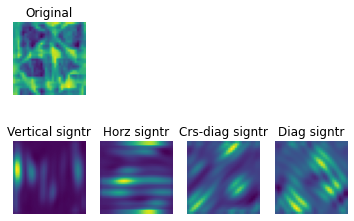

In [36]:
if __name__=='__main__':
    '''
    This program segments a grey image based on texture.
    It uses Gabor filters to identify texture signature of pixels,
    and Graph cut mechanism for segmentation.
    '''
    ## Read an image
    img=cv.imread('Dz68c.bmp',0)
#    img=np.zeros([32,32])
#    img[::3,:16:3]=255
#    img[::10,17::10]=150
    
    ## Create texture signature
    tsimg=createTextSign(img)
  
    ## Plot results
    
    showResults(img,tsimg)